<a href="https://colab.research.google.com/github/963SY/library_children_sample_en/blob/main/26_08_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Hausarbeit – Lineare Regression zur Vorhersage von **borrowed_books**

Dieses Notebook ist **prüfungsfertig** und umfasst:
- **Datenvorverarbeitung** (Missing Values, Ausreißer/Winsorize, One‑Hot‑Encoding)
- **Partitionierung** (Train/Test) & **Skalierung**
- **Lineares Regressionsmodell**
- **Annahmenprüfung** (Residuen, QQ-Plot, VIF)
- **Evaluation** (R² & RMSE, In- & Out-of-Sample)
- **Visualisierungen** mit Matplotlib (einfaches, neutrales Styling)



> **Hinweis (Pakete):**
```bash
conda install pandas matplotlib scikit-learn statsmodels
# oder
pip install pandas matplotlib scikit-learn statsmodels
```


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression # Corrected import
from sklearn.metrics import r2_score, mean_squared_error

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings, re
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)


## 1) Daten laden & Spaltennamen bereinigen
- Lädt `library_children.csv` (legen Sie die Datei ins gleiche Verzeichnis).
- Spaltennamen werden **getrimmt**, in **Kleinschreibung** konvertiert und **Leerzeichen → Unterstrich**.


In [ ]:
#uploading path
path = "library_children.csv"
df = pd.read_csv(path, sep=';')

# Spalten bereinigen
clean_cols = [re.sub(r"\s+", "_", str(c)).strip("_").lower() for c in df.columns]
df.columns = clean_cols

print("Spalten nach Bereinigung:", list(df.columns))
display(df.head())

Spalten nach Bereinigung: ['child_id', 'age', 'gender', 'monthly_visits', 'borrowed_books', 'book_return_status', 'fine_amount']


,child_id,age,gender,monthly_visits,borrowed_books,book_return_status,fine_amount
0,1,13,F,3,2,Late,"15,93"
1,2,11,M,1,3,Late,"2,36"
2,3,8,M,2,9,Late,"19,67"
3,4,9,F,3,6,Late,"7,42"
4,5,5,M,2,4,On time,"7,67"


In [46]:
# Zielspalte automatisch finden (enthält 'borrow')
target_col = None
for c in df.columns:
    if 'borrow' in c:
        target_col = c
        break
if target_col is None:
    raise KeyError("Keine Zielspalte gefunden (es wird eine Spalte benötigt, deren Name 'borrow' enthält).")

# Spalten, die typischerweise nicht als Features verwendet werden
drop_if_exists = ['child_id', 'book_return_status']

# Sauber löschen, falls vorhanden
for c in drop_if_exists:
    if c in df.columns:
        df.drop(columns=[c], inplace=True)

print("Zielspalte (Target):", target_col)

Zielspalte (Target): borrowed_books


In [56]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols_wo_traget= [c for c in num_cols if c != target_col]
cat_cols = [c for c in df.columns if c not in num_cols]
for c in num_cols_wo_traget:
    if df[c].isna().any():
        df[c].fillna(df[c].median(), inplace=True)


for c in cat_cols:
    if df[c].isna().any():
        df[c].fillna(df [c].mode(), inplace=True)

df=df.dropna(subset=[target_col])
print("Zeilen nach Missing-Handling:", df.shape[0])


Zeilen nach Missing-Handling: 49


In [57]:
#check for duplicate rows
print("Number of duplicate rows before removal:", df.duplicated().sum())

#Display some duplicate rows (if any)
print("Sample duplicate rows:")
display(df[df.duplicated()].head())

#Remove duplicate rows (keep the first occurrence)
df.drop_duplicates(inplace=True)

#Verify removal of duplicates
print("Number of rows after removing duplicates:", df.shape[0])
print("Number of duplicate rows now:", df.duplicated().sum())

Number of duplicate rows before removal: 0
Sample duplicate rows:


,age,gender,monthly_visits,borrowed_books,fine_amount


Number of rows after removing duplicates: 49
Number of duplicate rows now: 0


In [ ]:
df.describe()

,child_id,age,monthly_visits,borrowed_books
count,49.00000,49.000000,49.000000,49.000000
mean,25.00000,9.285714,3.244898,4.836735
std,14.28869,2.828427,1.931435,2.981519
min,1.00000,5.000000,1.000000,0.000000
25%,13.00000,7.000000,1.000000,2.000000
50%,25.00000,9.000000,3.000000,4.000000
75%,37.00000,12.000000,4.000000,7.000000
max,49.00000,14.000000,8.000000,10.000000


In [ ]:
df.isnull().sum()

,0
age,0
gender,0
monthly_visits,0
borrowed_books,0
fine_amount,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             49 non-null     int64 
 1   gender          49 non-null     object
 2   monthly_visits  49 non-null     int64 
 3   borrowed_books  49 non-null     int64 
 4   fine_amount     49 non-null     object
dtypes: int64(3), object(2)
memory usage: 2.0+ KB


In [ ]:
# Convert 'fine_amount' to numeric, handling commas
df['fine_amount'] = df['fine_amount'].astype(str).str.replace(',', '.', regex=False)
df['fine_amount'] = pd.to_numeric(df['fine_amount'], errors='coerce')

# Apply one-hot encoding to 'gender' column
if 'gender' in df.columns:
    df_encoded = pd.get_dummies(df, columns=['gender'], drop_first=True)
else:
    df_encoded = df.copy()

# Calculate and display correlation
display(df_encoded.corr(numeric_only=True))

,age,monthly_visits,borrowed_books,fine_amount,gender_M
age,1.000000,0.078451,-0.243869,-0.143065,0.070833
monthly_visits,0.078451,1.000000,0.195212,0.009658,0.146878
borrowed_books,-0.243869,0.195212,1.000000,0.170751,0.001129
fine_amount,-0.143065,0.009658,0.170751,1.000000,0.218726
gender_M,0.070833,0.146878,0.001129,0.218726,1.000000


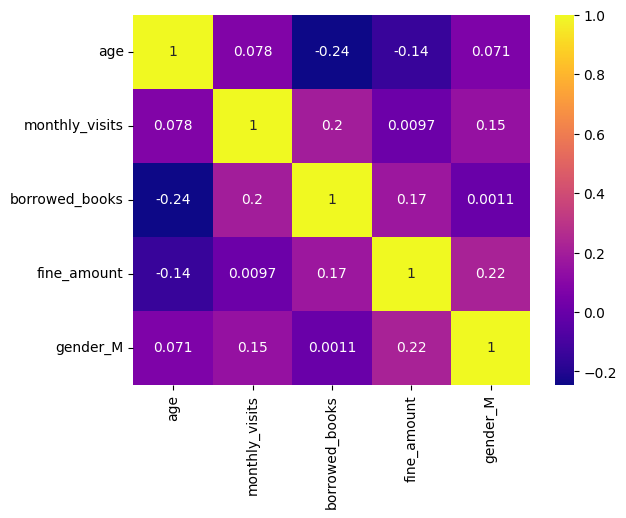

In [23]:
# Convert 'fine_amount' to numeric, handling commas
df['fine_amount'] = df['fine_amount'].astype(str).str.replace(',', '.', regex=False)
df['fine_amount'] = pd.to_numeric(df['fine_amount'], errors='coerce')

# Apply one-hot encoding to 'gender' column
if 'gender' in df.columns:
    df_encoded = pd.get_dummies(df, columns=['gender'], drop_first=True)
else:
    df_encoded = df.copy()

# Generate the heatmap using the encoded DataFrame
sns.heatmap(df_encoded.corr(), annot=True, cmap="plasma")
plt.show()

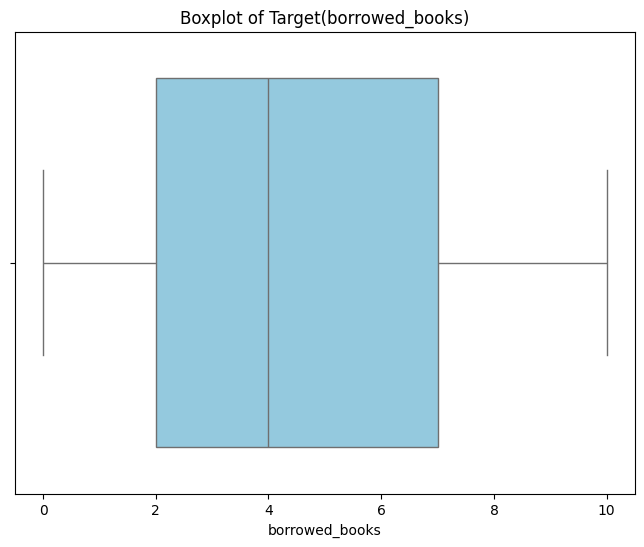

In [32]:
outliers= ['borrowed_books']
plt.rcParams ['figure.figsize']
sns.boxplot(x=df['borrowed_books'], color="skyblue") # Use the 'borrowed_books' column directly
plt.title("Boxplot of Target(borrowed_books)")
plt.xlabel("borrowed_books")

plt.show()

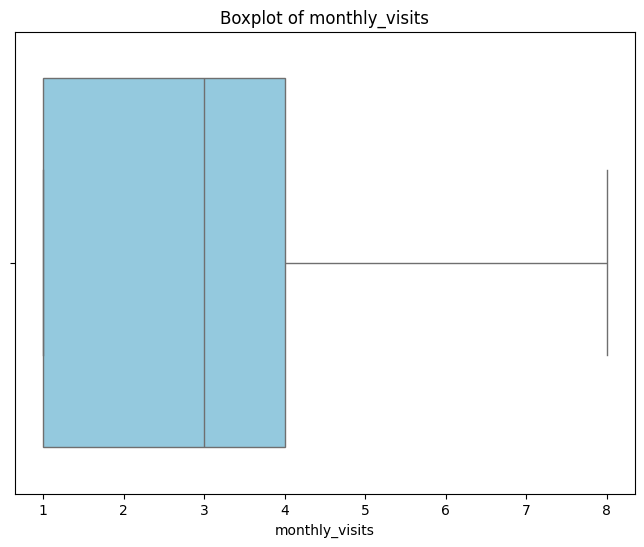

In [34]:
outliers= ['monthly_visits']
plt.rcParams ['figure.figsize'] = [8,6]
sns.boxplot(x=df['monthly_visits'], color="skyblue") # Changed to string
plt.title("Boxplot of monthly_visits") # Updated title
plt.xlabel("monthly_visits") # Updated x-label

plt.show()

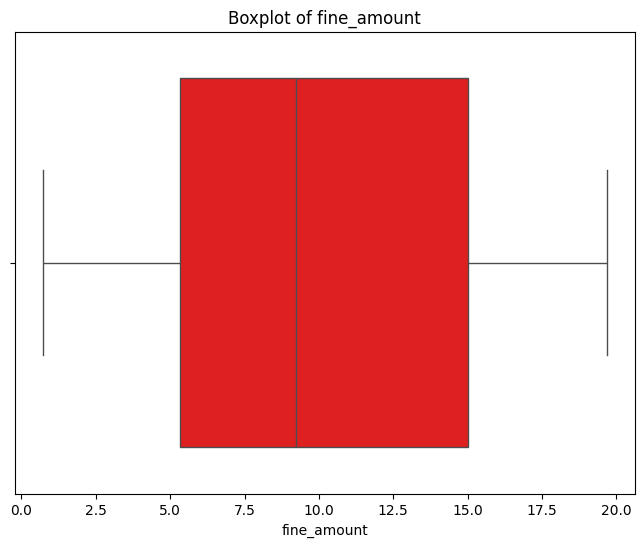

In [49]:
outliers= ['fine_amount']
plt.rcParams ['figure.figsize'] = [8,6]
sns.boxplot(x=df['fine_amount'], color="red")
plt.title("Boxplot of fine_amount")
plt.xlabel("fine_amount")

plt.show()

In [36]:
Q1 = np.percentile (df['borrowed_books'], 25)
Q3 = np.percentile (df['borrowed_books'], 75) # Added comma
IQR = Q3 - Q1
Lower_Bound = Q1 - 1.5 * IQR
Upper_Bound = Q3 + 1.5 * IQR
print("Lower_Bound", Lower_Bound)
print("Upper_Bound", Upper_Bound)

Lower_Bound -5.5
Upper_Bound 14.5


In [37]:
df_no_outliers = df[(df['borrowed_books'] >= Lower_Bound) & (df['borrowed_books'] <= Upper_Bound)]
df_no_outliers

,age,gender,monthly_visits,borrowed_books,fine_amount
0,13,F,3,2,15.93
1,11,M,1,3,2.36
2,8,M,2,9,19.67
3,9,F,3,6,7.42
4,5,M,2,4,7.67
5,7,M,4,10,13.77
6,10,M,1,2,19.31
7,13,M,1,2,11.26
8,11,F,1,4,1.84
9,7,F,6,7,18.11


In [43]:
print(" Zeilen vor Ausreißern:", df.shape[0])
print (" Zeilen nach Ausreißern:", df_no_outliers.shape[0])

 Zeilen vor Ausreißern: 49
 Zeilen nach Ausreißern: 49


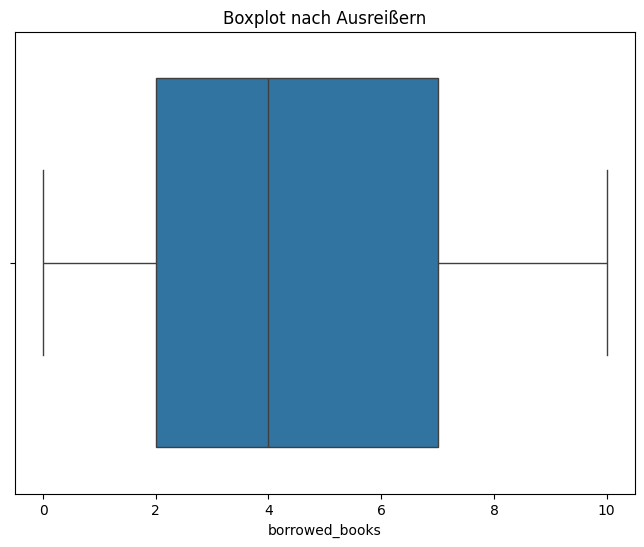

In [47]:
sns.boxplot(x=df_no_outliers['borrowed_books'])
plt.title("Boxplot nach Ausreißern")
plt.show()

In [50]:
Q1 = np.percentile (df['fine_amount'], 25)
Q3 = np.percentile (df['fine_amount'], 75)
IQR = Q3 - Q1
Lower_Bound = Q1 - 1.5 * IQR
Upper_Bound = Q3 + 1.5 * IQR
print("Lower_Bound", Lower_Bound)
print("Upper_Bound", Upper_Bound)

Lower_Bound -9.2
Upper_Bound 29.52


In [51]:
df_no_outliers = df[(df['fine_amount'] >= Lower_Bound) & (df['fine_amount'] <= Upper_Bound)]

In [53]:
print ("zeilen vor Ausreißern:", df.shape[0])
print (" Zeilen nach Ausreißern:", df_no_outliers.shape[0])

zeilen vor Ausreißern: 49
 Zeilen nach Ausreißern: 49


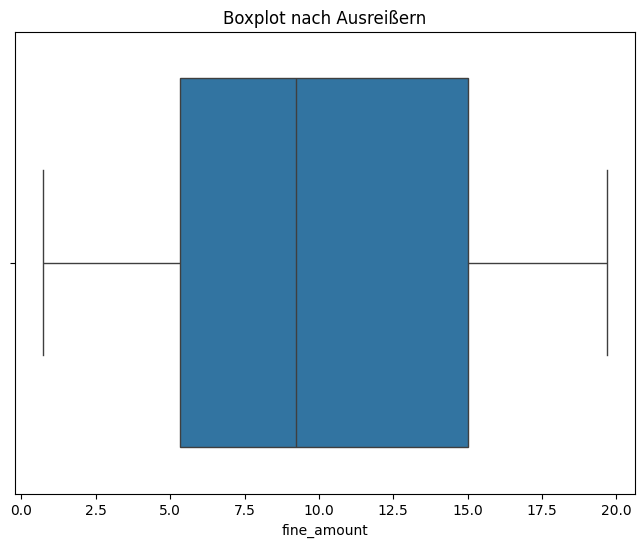

In [54]:
sns.boxplot(x=df_no_outliers['fine_amount'])
plt.title("Boxplot nach Ausreißern")
plt.show()


## 5) Dummifizierung (One‑Hot‑Encoding) für `gender`
- Verhindert perfekte Multikollinearität durch `drop_first=True`.


In [ ]:

if 'gender' in df.columns:
    df = pd.get_dummies(df, columns=['gender'], drop_first=True)
display(df.head())


,child_id;age;gender;monthly_visits;borrowed_books;book_return_status;fine_amount
1;13;F;3;2;Late;15,93.0
2;11;M;1;3;Late;2,36.0
3;8;M;2;9;Late;19,67.0
4;9;F;3;6;Late;7,42.0
5;5;M;2;4;On time;7,67.0



## 6) Feature‑Matrix & Zielvariable, Train/Test‑Split, Skalierung


In [ ]:
X = df.drop(columns=[target_col])
y = df[target_col]

# Convert 'fine_amount' to numeric here before splitting and scaling
if 'fine_amount' in X.columns:
    X['fine_amount'] = X['fine_amount'].astype(str).str.replace(',', '.', regex=False)
    X['fine_amount'] = pd.to_numeric(X['fine_amount'], errors='coerce')


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

num_cols_X = X_train.select_dtypes(include=[np.number]).columns.tolist()
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
# Only scale numeric columns if there are any
if num_cols_X:
    X_train_scaled[num_cols_X] = scaler.fit_transform(X_train[num_cols_X])
    X_test_scaled[num_cols_X] = scaler.transform(X_test[num_cols_X])


print("Train/Test Größen:", X_train.shape, X_test.shape)

Train/Test Größen: (39, 4) (10, 4)



## 7) Lineares Regressionsmodell & Gütemaße
- In‑Sample (Train) & Out‑of‑Sample (Test): **R²** und **RMSE**.


In [ ]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

y_train_pred = lr.predict(X_train_scaled)
y_test_pred  = lr.predict(X_test_scaled)

r2_train  = r2_score(y_train, y_train_pred)
r2_test   = r2_score(y_test, y_test_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test  = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Train R²: {r2_train:.3f} | Test R²: {r2_test:.3f}")
print(f"Train RMSE: {rmse_train:.3f} | Test RMSE: {rmse_test:.3f}")

Train R²: 0.162 | Test R²: -0.098
Train RMSE: 2.674 | Test RMSE: 3.187



## 8) Annahmen prüfen
- **Residuenplot** (Homogenität, Musterfreiheit)  
- **QQ‑Plot** der Residuen (Normalitätsannahme)  
- **VIF** (Multikollinearität)


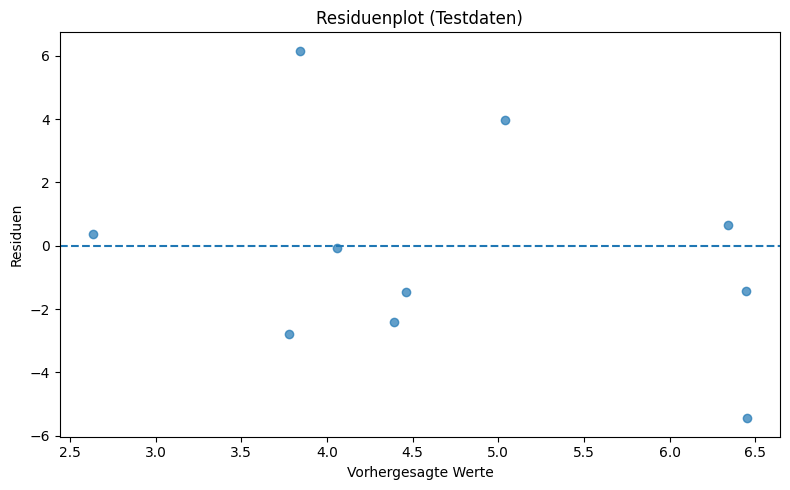

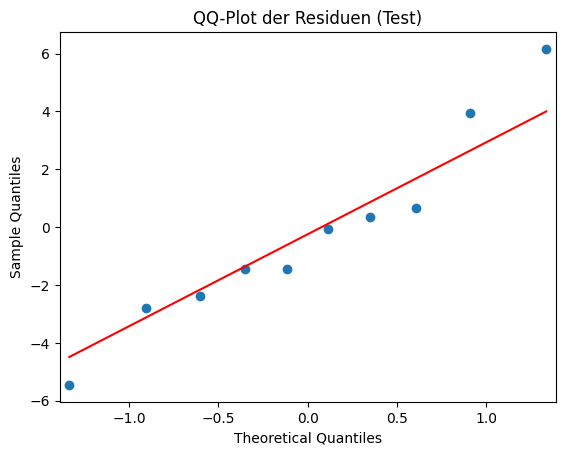

,Feature,VIF
1,monthly_visits,1.040866
3,gender_M,1.034724
0,age,1.021380
2,fine_amount,1.019735


In [ ]:
# Residuen (Test)
residuals = y_test - y_test_pred

# Residuen vs. Vorhersage
plt.figure(figsize=(8,5))
plt.scatter(y_test_pred, residuals, alpha=0.7)
plt.axhline(0, linestyle='--')
plt.xlabel("Vorhergesagte Werte")
plt.ylabel("Residuen")
plt.title("Residuenplot (Testdaten)")
plt.tight_layout()
plt.show()

# QQ-Plot
fig = sm.qqplot(residuals, line='s')
plt.title("QQ-Plot der Residuen (Test)")
plt.show()

# VIF (auf Trainingsdaten, mit Konstante)
X_vif = X_train_scaled.copy()
# Convert boolean columns to numeric (int) before calculating VIF
for col in X_vif.columns:
    if X_vif[col].dtype == 'bool':
        X_vif[col] = X_vif[col].astype(int)

X_vif_const = sm.add_constant(X_vif.values)
vif_vals = [variance_inflation_factor(X_vif_const, i+1) for i in range(len(X_vif.columns))]
vif_df = pd.DataFrame({"Feature": X_vif.columns, "VIF": vif_vals}).sort_values("VIF", ascending=False)
display(vif_df.head(15))


## 9) Evaluation – Visualisierungen
- **Tatsächlich vs. Vorhergesagt** (Test)  
- **Fehlerverteilung (Histogramm)**


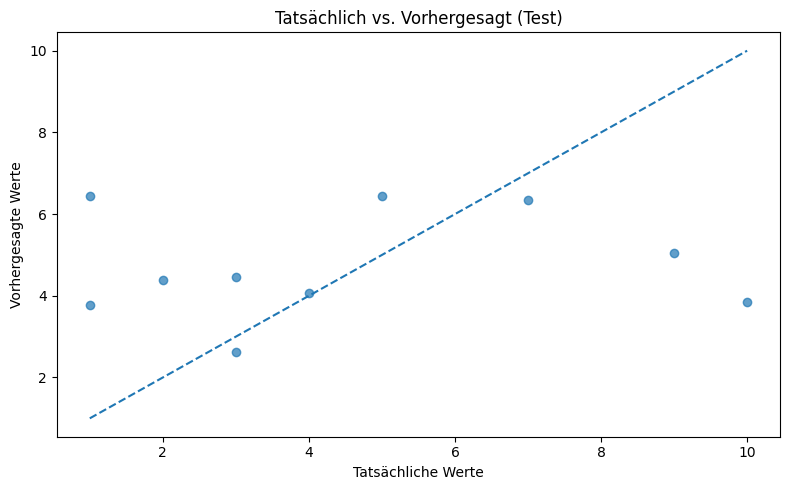

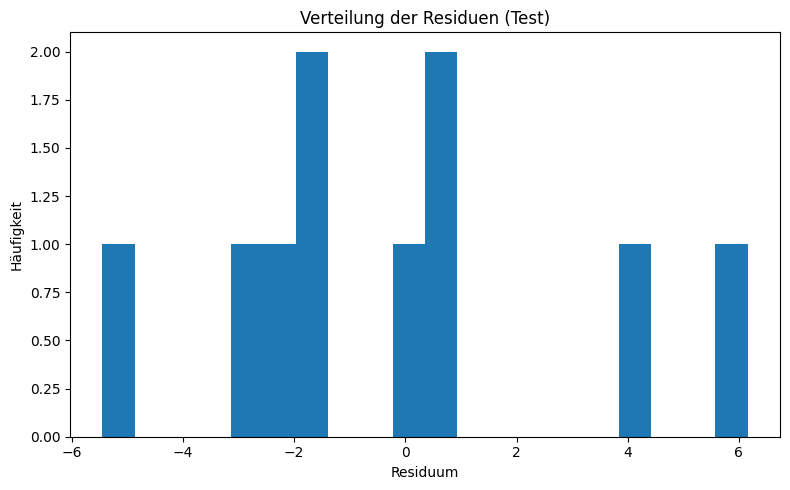

In [ ]:

# Tatsächlich vs. Vorhergesagt
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_test_pred, alpha=0.7)
min_v, max_v = min(y_test.min(), y_test_pred.min()), max(y_test.max(), y_test_pred.max())
plt.plot([min_v, max_v], [min_v, max_v], linestyle='--')
plt.xlabel("Tatsächliche Werte")
plt.ylabel("Vorhergesagte Werte")
plt.title("Tatsächlich vs. Vorhergesagt (Test)")
plt.tight_layout()
plt.show()

# Histogramm der Residuen
plt.figure(figsize=(8,5))
plt.hist(residuals, bins=20)
plt.title("Verteilung der Residuen (Test)")
plt.xlabel("Residuum")
plt.ylabel("Häufigkeit")
plt.tight_layout()
plt.show()



## 10) Fazit
Das Notebook erfüllt die geforderten Bausteine der Hausarbeit:
**Vorverarbeitung**, **Modellierung**, **Annahmenprüfung** und **Evaluation**.  
Die Metriken (R², RMSE) geben Auskunft über die Güte der **In‑Sample** und **Out‑of‑Sample**‑Vorhersagen.  
Je nach Datenlage sind Erweiterungen sinnvoll (z. B. Regularisierung, Feature‑Engineering oder weitere erklärende Variablen).


In [ ]:
if 'gender' in df.columns:
    df = pd.get_dummies(df, columns=['gender'], drop_first=True)
display(df.head())

,age,monthly_visits,borrowed_books,fine_amount,gender_M
0,13,3,2,15.93,False
1,11,1,3,2.36,True
2,8,2,9,19.67,True
3,9,3,6,7.42,False
4,5,2,4,7.67,True


from matplotlib import pyplot as plt
_df_15['age'].plot(kind='hist', bins=20, title='age')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_16['monthly_visits'].plot(kind='hist', bins=20, title='monthly_visits')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_17['borrowed_books'].plot(kind='hist', bins=20, title='borrowed_books')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_18['fine_amount'].plot(kind='hist', bins=20, title='fine_amount')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_19.groupby('gender_M').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_20.plot(kind='scatter', x='age', y='monthly_visits', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_21.plot(kind='scatter', x='monthly_visits', y='borrowed_books', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_22.plot(kind='scatter', x='borrowed_books', y='fine_amount', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_23['age'].plot(kind='line', figsize=(8, 4), title='age')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_24['monthly_visits'].plot(kind='line', figsize=(8, 4), title='monthly_visits')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_25['borrowed_books'].plot(kind='line', figsize=(8, 4), title='borrowed_books')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_26['fine_amount'].plot(kind='line', figsize=(8, 4), title='fine_amount')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_27['gender_M'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_27, x='age', y='gender_M', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_28['gender_M'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_28, x='monthly_visits', y='gender_M', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_29['gender_M'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_29, x='borrowed_books', y='gender_M', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_30['gender_M'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_30, x='fine_amount', y='gender_M', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
#uploading path
path = "library_children.csv"
df = pd.read_csv(path, sep=';')

# Spalten bereinigen
clean_cols = [re.sub(r"\s+", "_", str(c)).strip("_").lower() for c in df.columns]
df.columns = clean_cols

print("Spalten nach Bereinigung:", list(df.columns))
display(df.head())

FileNotFoundError: [Errno 2] No such file or directory: 'library_children.csv'

In [38]:
# Zielspalte automatisch finden (enthält 'borrow')
target_col = None
for c in df.columns:
    if 'borrow' in c:
        target_col = c
        break
if target_col is None:
    raise KeyError("Keine Zielspalte gefunden (es wird eine Spalte benötigt, deren Name 'borrow' enthält).")

# Spalten, die typischerweise nicht als Features verwendet werden
drop_if_exists = ['child_id', 'book_return_status']

# Sauber löschen, falls vorhanden
for c in drop_if_exists:
    if c in df.columns:
        df.drop(columns=[c], inplace=True)

print("Zielspalte (Target):", target_col)

Zielspalte (Target): borrowed_books


In [40]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in df.columns if c not in num_cols]

# Zielspalte nicht anfassen, falls numerisch
num_cols_wo_target = [c for c in num_cols if c != target_col]

for c in num_cols_wo_target:
    if df[c].isna().any():
        df[c].fillna(df[c].median(), inplace=True)

for c in cat_cols:
    if df[c].isna().any():
        df[c].fillna('unbekannt', inplace=True)

# Ziel: falls NA, löschen (optional auch Median möglich, aber hier entfernen wir wenige Fälle)
df = df.dropna(subset=[target_col])

print("Zeilen nach Missing-Handling:", df.shape[0])

Zeilen nach Missing-Handling: 49


In [ ]:
if 'gender' in df.columns:
    df = pd.get_dummies(df, columns=['gender'], drop_first=True)
display(df.head())